## AutoGIS Final Assignment, Hanna Hirvonen

# AccessViz
#### What is AccessViz?
AccessViz is a Python and GIS-tool that visualizes and compares travel times by different travel modes in the Helsinki Region, Finland. The tool has four main components for accessing the files (FileFinder), joining the attribute information to spatial data (TableJoiner), visualizing the data (Visualizer), and comparing different travel modes (Comparison Tool).

#### Data
The Helsinki Region Travel Time Matrix Data can be downloaded from http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/.
The data is available for years 2013, 2015, and 2018. You can find further information on the Travel Time Matrix in the Digital Geography Lab / Accessibility Research blog of University of Helsinki: http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/.

YKR grid cell ID values can be found in an attribute table that can be downloaded from http://www.helsinki.fi/science/accessibility/data/MetropAccess-matka-aikamatriisi/MetropAccess_YKR_grid.zip. You can get familiar with the locations of individual YKR grid cells by checking out this webmap by University of Helsinki: http://www.helsinki.fi/science/accessibility/tools/YKR/YKR_Identifier.html.

Four Travel Time Matrix files from 2018 are used in the example code to demonstrate how the tool works.

### FileFinder

FileFinder finds a list of Travel Time Matrix files according to an input list of YKR ID values. If a YKR ID is not found in a specified input folder nor its subfolders, the tool warns the user but continues running. The tool also informs the user of the execution process.

In [1]:
#Importing the necessary modules:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import folium
import requests
import geojson
import contextily as ctx
%matplotlib inline

#Creating empty lists for the YKR IDs and the filepaths:
ykr_ids=[]
user_fps=[]

#The user creates a list of YKR IDs:
print("FileFinder\n\nEnter the YKR IDs one by one for the analysis.\nPress the enter-key after each ID.\nEnter '0' when finished.")
while True:
    ele=int(input()) #the user enters a YKR ID
    if ele==0:
        break
    else:
        ykr_ids.append(ele)

#The user defines the input folder:
input_fp = str(input("Enter the filepath to the input folder containing the Travel Time Matrix files:"))

#Defining a function for getting updates about the state of the process:
def state(n, list_length, last_file):
    """
    A function for printing updates of the processes in FileFinder and TableJoiner.
    Inputs:
    n: ordinal number (int) of the current index in a list, such as 2 in 2/5
    list_length: total length of the list (int)
    last_file: the name of the last file processed (string)
    """
    if n!=len(ykr_ids):
        print("Process:",n,"/",list_length,", last file processed:",last_file,end="\r") #the previous statement is removed once the process moves on
    else:
        print("Process:",n,"/",list_length,", last file processed:",last_file,"\nAll files processed.")
    return None

#Searching for corresponding .txt files from the input folder:
n=1
for i in ykr_ids:
    file=input_fp+"travel_times_to_ "+str(i)+".txt"
    globfile=str(glob.glob(file)) #this creates the file if it exists in the input directory
    s_globfile = globfile[slice(2,-2)]
    if (s_globfile!=file):
        print("A file corresponding to the YKR ID "+str(i)+" not found in the input folder!") #notifying the user if a file is not found
    user_fps.append(s_globfile)
    state(n, len(ykr_ids), s_globfile[5:])
    n=n+1

FileFinder

Enter the YKR IDs one by one for the analysis.
Press the enter-key after each ID.
Enter '0' when finished.


 5785640
 5785641
 5785642
 5785643
 0
Enter the filepath to the input folder containing the Travel Time Matrix files: data/


Process: 4 / 4 , last file processed: travel_times_to_ 5785643.txt 
All files processed.


### TableJoiner
Tablejoiner joins the Matrix file with MetropAccess YKR grid shapefile by using a corresponding column of YKR IDs. The resulting Shapefile is then saved to an output folder defined by the user. 

In [2]:
#Reading the grid-shapefile into a new GeoDataFrame:
grid_fp="data/grid/MetropAccess_YKR_grid_EurefFIN.shp"
grid=gpd.read_file(grid_fp)

#The user defines the output folder:
output_fp=str(input("TableJoiner\n\nEnter the filepath to the output folder for the joined table:"))

#Reading the YKR cells from the filepaths into new dataframes and joining them with the grid:
merged_fps=[] #creating an empty table for the filepaths to the joined/merged tables
n=1
for i in user_fps:
    df=pd.read_csv(i, sep=";")
    file_name=i[slice(21,-4)]+".shp"
    merged_grid=grid.merge(df, left_on='YKR_ID', right_on='from_id')
    merged_grid.replace(to_replace=-1, value=np.nan, inplace=True) #finding no data -values
    merged_grid.dropna(inplace=True) #removing no data -values
    output=os.path.join(output_fp, file_name)
    merged_grid.to_file(output)
    merged_fps.append(file_name)
    state(n, len(user_fps), file_name)
    n=n+1

TableJoiner

Enter the filepath to the output folder for the joined table: data/output/joined_shapefile/


Process: 4 / 4 , last file processed:  5785643.shp 
All files processed.


### Visualizer
Visualizer visualizes travel times of the selected YKR grid cells on four possible travel modes: 1) car, 2) public transport, 3) walking, and 4) biking. The user decides which modes are visualized, where the results are saved, and whether  the map is going to be static or interactive. 

Visualizer

Enter which traveling modes are visualized one by one (car, public transport, walking, biking).
Press the enter-key in an empty cell when finished:


 car
 
Enter 'static' for a static map or 'interactive' for an interactive map: static
Enter the output filepath for saving the visualizations: data/output/static_maps/


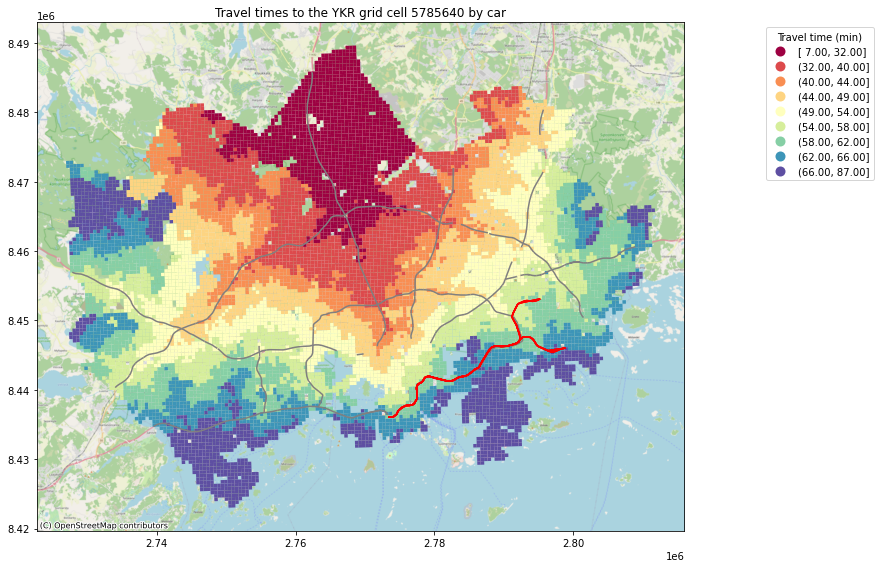

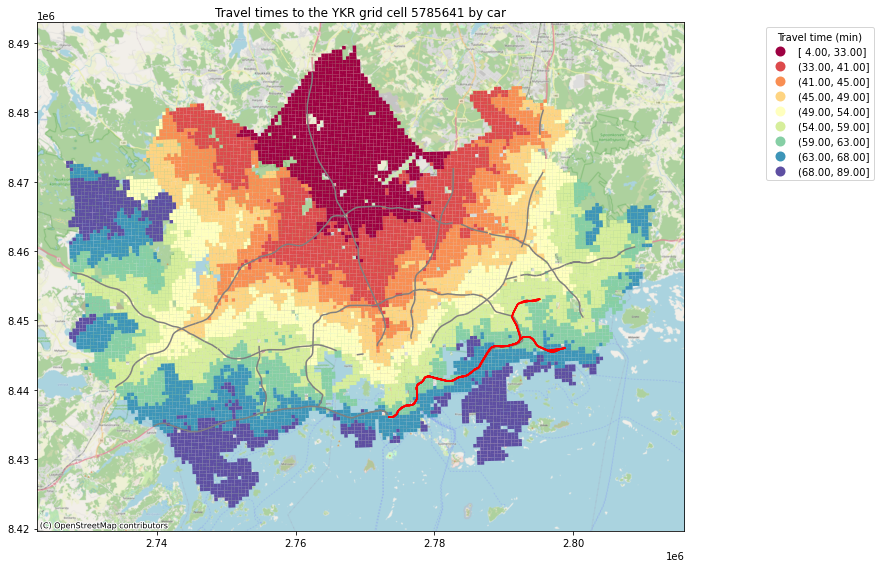

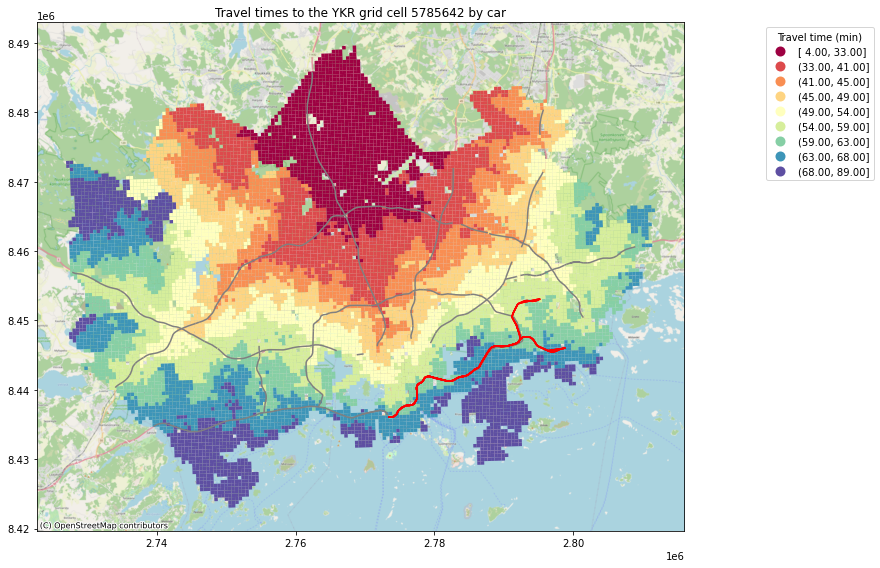

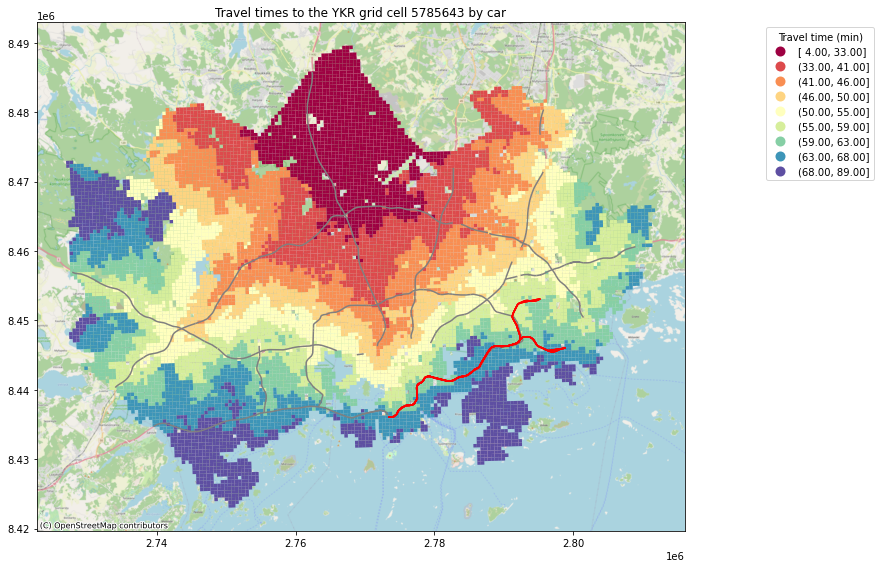

In [3]:
#The user determines which traveling modes are visualized:
print("Visualizer\n\nEnter which traveling modes are visualized one by one (car, public transport, walking, biking).\nPress the enter-key in an empty cell when finished:")
modes=[] #an empty list for storing the selected travel modes
while True:
    ele=str(input())
    if ele=='':
        break
    else:
        modes.append(ele)
        
#The user determines whether the map is static or interactive:
s_or_ia=input("Enter 'static' for a static map or 'interactive' for an interactive map:")

#The user determines the output folder for the maps:
output_vis=input("Enter the output filepath for saving the visualizations:")

#Creating new GeoDataFrames for the road and metro networks:
metro_fp="data/metro.shp"
roads_fp="data/roads.shp"
roads=gpd.read_file(roads_fp)
metro=gpd.read_file(metro_fp)
roads = roads.to_crs(epsg=3857) #the coordinate systems are changed
metro = metro.to_crs(epsg=3857)

#Defining a function for retrieving a correct Travel Time Matrix column name:
def get_column_t(mode):
    """
    A function for getting a correct Travel Time Matrix column name for travel time values based on a traveling mode.
    Input: traveling mode (string), such as 'biking'
    Returns: a column name (string) from the Helsinki Region Travel Time Matrix
    """
    if mode=="car":
        col="car_r_t" #r=rush hour, t=time
    elif mode=="public transport":
        col="pt_r_t"
    elif mode=="walking":
        col="walk_t"
    elif mode=="biking":
        col="bike_f_t" #f=fast biking
    return col

#Defining a function for creating and saving a static map:
def static_map(gdf,mode,file_name):
    """
    A function for creating and saving a static map of travel times to a specific YKR grid cell.
    The map is saved in png-format.
    Inputs:
    gdf: joined GeoDataFrame with the Matrix and YKR data
    mode: name of the traveling mode (string)
    file_name: name of the current file (string)
    """
    col=get_column_t(mode)
    fig,ax=plt.subplots(figsize=(12,8))
    gdf.plot(ax=ax, 
              column=col, 
              linewidth=0.03, 
              cmap="Spectral", 
              scheme="quantiles", 
              k=9, 
              legend=True, 
              )
    ax.get_legend().set_bbox_to_anchor((1.3,1))
    ax.set_title("Travel times to the YKR grid cell"+file_name[0:-4]+" by "+mode)
    roads.plot(ax=ax, color="grey", linewidth=1.5)
    metro.plot(ax=ax, color="red", linewidth=1.5)
    legend_title="Travel time (min)"
    ax.get_legend().set_title(legend_title)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) #adding a basemap
    plt.tight_layout()
    out_fp=output_vis+file_name[0:-4]+"_"+mode+".png"
    plt.savefig(out_fp, dpi=300) #saving the figure
    return None

#Defining a function for creating and saving an interactive map:
def interactive_map(gdf, mode, file_name):
    """
    A function for creating and saving an interactive map of travel times to a specific YKR grid cell.
    The map is saved in .html-format.
    Inputs:
    gdf: joined GeoDataFrame with the Matrix and YKR data
    mode: name of the traveling mode (string)
    file_name: name of the current file (string)
    """
    gdf["geoid"]=gdf.index.astype(str)
    mode_col=get_column_t(mode)
    gdf=gdf[["geoid",mode_col,"geometry"]]
    title="Travel time by "+mode
    legend_title="Travel time (min) by "+mode
    m=folium.Map(location=[60.25, 24.8], 
                 tiles="cartodbpositron", 
                 zoom_start=10, 
                 control_scale=True)
    folium.Choropleth( #creating a choropleth map
    geo_data=gdf,
    name=title,
    data=gdf,
    columns=["geoid", mode_col],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color="white", 
    line_weight=0,
    highlight=False, 
    smooth_factor=1.0,
    legend_name=legend_title).add_to(m)
    out_fp=output_vis+file_name[0:-5]+"_"+mode+".html"
    m.save(out_fp) #saving the figure
    m
    return None

#Defining a function for creating a GeoDataFrame in a for-loop based on a file name
def get_gdf(file_name):
    """
    A function for creating ang getting the correct GeoDataFrame according to a file name.
    Input: file name (string)
    Returns: corresponding GeoDataFrame
    """
    filepath=output_fp+file_name
    gdf=gpd.read_file(filepath)
    gdf=gdf.to_crs(epsg=3857) #changing the crs
    return gdf

#Iterating over the modes the user has selected and visualizing the results by calling the correct functions:
for i in modes:
    for file_name in merged_fps:
        merged=get_gdf(file_name)
        merged.head()
        if s_or_ia=="static":
            static_map(merged, i, file_name)
        elif s_or_ia=="interactive":
            interactive_map(merged, i, file_name)
            

### Comparison Tool
Comparison tool compares travel times or travel distances of two different traveling modes defined by the user. The calculation is done based on the order of the inputs: the first mode is substracted by the second. The outputs are saved as Shapefiles. If invalid parameters are given, the tool stops the program and offers advise on what values are acceptable. 

AccessViz can be run without doing any comparisons.  

In [8]:
#Creating an empty list for the compared modes:
comparisons=[]

#Defining a function for asserting if a traveling mode is typed correctly:
def mode_check(input):
    """
    A function for asserting if a travel mode is typed correctly.
    Input: travel mode typed by an user (string)
    """
    assert input=="car" or input=="public transport" or input=="walking" or input=="biking", "Invalid parameter given. Valid travel modes are: car, public transport, walking, and biking"
    return None

#The user determines if a comparison is done and which travel modes are compared:
print("Comparison Tool\n\nEnter two traveling modes (car, public transport, walking, biking) one at the time for a comparison\nThe first mode is going to be substracted by the second (1 - 2).")
print("If you do not want to do any comparison, press the enter-key in an empty cell.")
n=1
while n<3:
    ele=input() #the user enters a YKR ID
    mode_check(ele)
    if ele=="":
        break
    else:
        comparisons.append(ele)
    n=n+1
    
#The user decides whether the time or distance is compared:
t_or_d=input("Enter 'time' to compare travel times or 'distance' to compare travel distances:")

#Defining a function to get a column name with distance values:
def get_column_d(mode):
    """
    A function for getting a correct Travel Time Matrix column name for travel distance values based on a traveling mode.
    Input: traveling mode (string), such as 'biking'
    Returns: a column name (string) from the Helsinki Region Travel Time Matrix
    """
    if mode=="car":
        col="car_r_d" #d=distance
    elif mode=="public transport":
        col="pt_r_d"
    elif mode=="walking":
        col="walk_d"
    elif mode=="biking":
        col="bike_d"
    return col

#Defining a function for visualizing the comparisons:
def comp_visualization(gdf, file_name, col_name, mode1, mode2):
    """
    A function for interactively visualizing the comparison results.
    The map is saved in .html format.
    Inputs:
    gdf: GeoDataFrame with the comparison data
    file_name: name of the current file
    col_name: name of the column with the calculated comparison
    mode1: first travel mode
    mode2: second travel mode
    """
    gdf["geoid"]=gdf.index.astype(str)
    gdf=gdf[["geoid",col_name,"geometry"]]
    title="Difference in the travel "+t_or_d+" between "+mode1+" and "+mode2+" in the YKR grid cell "+file_name[0:-4]
    if t_or_d=="time":
        legend_title="Difference in minutes"
    elif t_or_d=="distance":
        legend_title="Difference in kilometers"
    m=folium.Map(location=[60.25, 24.8], 
                 tiles="cartodbpositron", 
                 zoom_start=10, 
                 control_scale=True)
    folium.Choropleth(
    geo_data=gdf,
    name=title,
    data=gdf,
    columns=["geoid", col_name],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color="white", 
    line_weight=0,
    highlight=False, 
    smooth_factor=1.0,
    legend_name=legend_title).add_to(m)
    out_fp=file_name[0:-4]+"_comparison_"+mode1+"_"+mode2+"_"+t_or_d+".html"
    m.save(out_fp)
    m
    return None

#The substraction is made based on the selected traveling modes:
for file_name in merged_fps:
    n=1
    merged=get_gdf(file_name)
    for i in comparisons:
        if t_or_d=="time":
            col=get_column_t(i)
        elif t_or_d=="distance":
            col=get_column_d(i)
        if n==1:
            merged["first"]=merged[col]
            f=i
        else:
            s=i
            merged["second"]=merged[col]
            col_name=f+"_"+s
            merged[col_name]=merged["first"]-merged["second"] #the calculation
            del merged["first"] #deleting unnecessary columns
            del merged["second"]
            merged.to_file("Accessibility_"+file_name[0:-4]+"_"+f+"_vs_"+s+".shp")
            comp_visualization(merged, file_name, col_name, f, s)
        n=n+1

Comparison Tool

Enter two traveling modes (car, public transport, walking, biking) one at the time for a comparison
The first mode is going to be substracted by the second (1 - 2).
If you do not want to do any comparison, press the enter-key in an empty cell.


 car
 public transport
Enter 'time' to compare travel times or 'distance' to compare travel distances: time
